This is an example of using Python calculate and plot the motion of a double pendulum, in this case using the Hamiltonian formalism. The motion is calculated by integration of a set of four Hamilton's first-order differential equations. Order of variables in the array u[]:
1.   $u[0]= \phi\quad$ Angle of the upper pendulum, measured from the vertical.
1.   $u[1]=p_\phi\quad$  Angular velocity of the upper pendulum.
1.   $u[2]= \theta\quad$ Angle of the lower pendulum, measured from the vertical.
1.   $u[3]=p_\theta\quad$  Angular velocity of the lower pendulum.

The equations of motion follow from the Hamiltonian:
$$H={1\over 2m\ell^2(2-\cos^2(\phi-\theta))}
\left[p_\phi^2 +2p_\theta^2 -2\cos(\phi-\theta)p_\phi p_\theta\right]-mg\ell(2\cos\phi+\cos\theta)$$
The resulting Hamilton equations are
$${d\phi\over dt}={\partial H\over\partial p_\phi} ={p_\phi-\cos(\phi-\theta)p_\theta\over m\ell^2\left[2-\cos^2(\phi-\theta)\right]}$$

$${dp_\phi\over dt}=-{\partial H\over\partial\phi}={-\sin(\phi-\theta)p_\phi p_\theta\over m\ell^2\left[2-\cos^2(\phi-\theta)\right]}
+{p_\phi^2 + 2p_\theta^2-2\cos(\phi-\theta)p_\phi p_\theta\over m\ell^2\left[2-\cos^2(\phi-\theta)\right]^2}\cos(\phi-\theta)\sin(\phi-\theta) - 2mg\ell\sin\phi$$

$${d\theta\over dt}={\partial H\over\partial p_\theta}={2p_\theta -\cos(\phi-\theta)p_\phi\over m\ell^2\left[2-\cos^2(\phi-\theta)\right]}$$

$${dp_\theta\over dt}=-{\partial H\over\partial \theta}={\sin(\phi-\theta)p_\phi p_\theta\over m\ell^2\left[2-\cos^2(\phi-\theta)\right]}
-{p_\phi^2 + 2p_\theta^2-2\cos(\phi-\theta)p_\phi p_\theta\over m\ell^2\left[2-\cos^2(\phi-\theta)\right]^2}\cos(\phi-\theta)\sin(\phi-\theta) - mg\ell\sin\theta $$

These four equations are coded into the function dudt below and form the basis of the numerical integration done by the scipy routine odeint. The Hamiltonian is also encoded into a function, which is used to check that the energy is the same before and after the motion. That is useful for finding bugs as well as for checking for excessive numerical error.

In [2]:
#%matplotlib tk
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import math

In [11]:
# Parameters describing the pendulum. Assume pendulum arms of equal length.
L = 2                     # length of each pendulum in m
g = 9.8                   # acceleration of gravity in m/s^2
mass = 1.0                # appears in the equations but cancels out

# Assign initial conditions to the motion.
phi0 = 135.*math.pi/180.               # initial angle of 1st pendulum in radians
pphi0 = 0.
theta0 = 45.*math.pi/180.              # initial angle of 2nd pendulum in radians
ptheta0 = 0.                          
u0 = [phi0, pphi0, theta0, ptheta0]  # initial conditions for all 4 variables
print ("Initial angle of the upper pendulum: phi = " + str(phi0) + " radians")
print ("Initial value of the momentum conjugate to phi = " + str(pphi0))
print ("Initial angle of the lower pendulum: theta = " + str(theta0) + " radians")
print ("Initial value of the momentum conjugate to theta = " + str(ptheta0))

# Calculate and print the natural frequencies (not used in the integration)
omega0 = math.sqrt(g/L)
print("Natural frequency of a single pendulum=" + str(omega0))
omega1 = omega0*math.sqrt(2.0-math.sqrt(2.0))
tau1 = 2.0*math.pi/omega1
print ("Frequency of the 1st small-oscillation eigenmode=" + str(omega1))
omega2 = omega0*math.sqrt(2.0+math.sqrt(2.0))
tau2 = 2.0*math.pi/omega2
print ("Frequency of the 2nd small-oscillation eigenmode=" + str(omega2))

Initial angle of the upper pendulum: phi = 2.356194490192345 radians
Initial value of the momentum conjugate to phi = 0.0
Initial angle of the lower pendulum: theta = 0.7853981633974483 radians
Initial value of the momentum conjugate to theta = 0.0
Natural frequency of a single pendulum=2.2135943621178655
Frequency of the 1st small-oscillation eigenmode=1.6942117767185523
Frequency of the 2nd small-oscillation eigenmode=4.090189048886147


In [4]:
# This function gives the time derivative of each of the 4 variables. These follow from the Hamilton equations of motion.
def dudt(u, t):
    r = [0., 0., 0., 0.]
    denom = 2.0 - pow(math.cos(u[0]-u[2]),2)
    A = math.sin(u[0]-u[2])*u[1]*u[3]/(mass*L*L*denom)
    B = (u[1]*u[1] + 2.*u[3]*u[3] - 2.*math.cos(u[0]-u[2])*u[1]*u[3])/(mass*L*L*denom*denom)
    C = math.cos(u[0]-u[2])*math.sin(u[0]-u[2])
    r[0] = (u[1] - math.cos(u[0]-u[2])*u[3])/(mass*L*L*denom)
    r[1] = -A + B*C - 2.*mass*g*L*math.sin(u[0])
    r[2] = (2*u[3] - math.cos(u[0]-u[2])*u[1])/(mass*L*L*denom)
    r[3] = A - B*C - mass*g*L*math.sin(u[2]) 
    return r

def H(u):  # The Hamiltonian, to verify that the conserved energy does not change (e.g. due to numerical errors).
    cDiff = math.cos(u[0]-u[2])
    denom = 2.*mass*L*L*(2.-cDiff*cDiff)
    T = (u[1]*u[1]+2.*u[3]*u[3]-2.*cDiff*u[1]*u[3])/denom
    U = -mass*g*L*(2.*math.cos(u[0])+math.cos(u[2]))
    E = T + U
    return E

The initial energy is 13.859292911256329
The final energy is 13.859339631830757


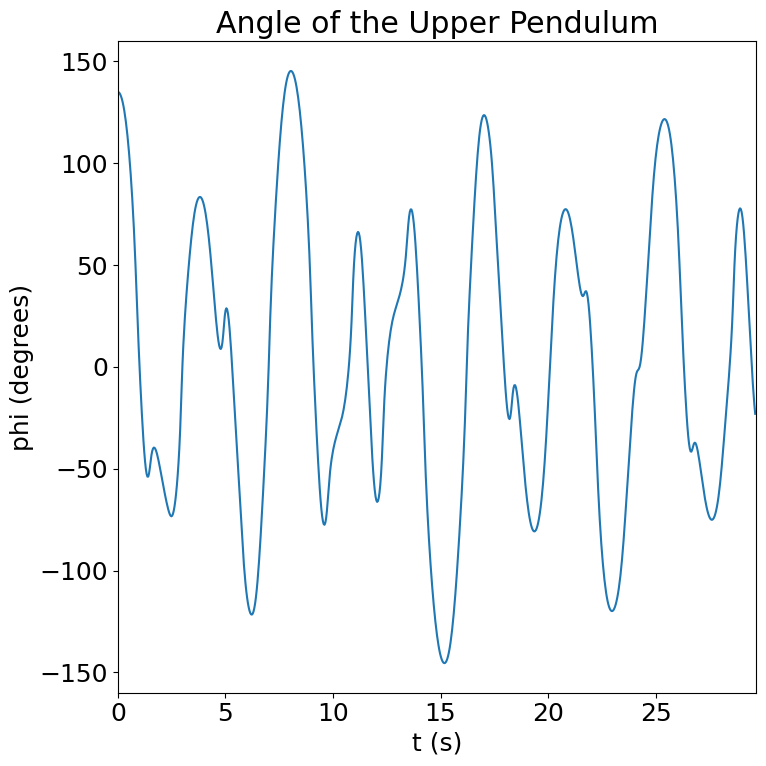

In [5]:
# Use the scipy odeint routine to carry out the numerical integration of the system of equations.
t0 = 0.                   # start time
t1 = 8.0*tau1             # end time
N = 800                   # number of time steps

# Choose a set of time values at which to evaluate the solution y(t)
t = np.arange(t0,t1, (t1-t0)/N)

# Call the routing from scipy that does the integration
u = odeint(dudt, u0, t)

Einitial = H(u0)
Efinal = H(u[N-1,...])
print("The initial energy is " + str(Einitial))
print("The final energy is " + str(Efinal))

font = {'size'   : 18}
plt.rc('font', **font)

# Use pyplot from matplotlib to plot the motion phi1(t)
fig, ax = plt.subplots(figsize=(8,8))
plt.xlim(t0, t1)
ax.set_xlabel('t (s)')
ax.set_ylabel('phi (degrees)')
plt.title('Angle of the Upper Pendulum')
ax.plot(t,u[...,0]*180./math.pi)
plt.tight_layout()
plt.show()

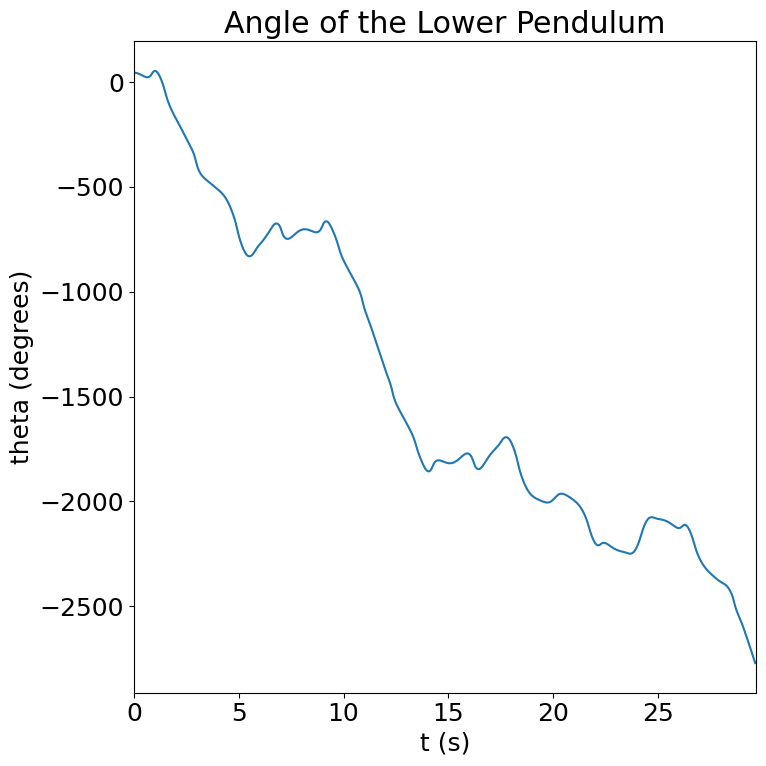

In [6]:
# Plot the motion phi2(t)
fig, ax = plt.subplots(figsize=(8,8))
plt.xlim(t0, t1)
ax.set_xlabel('t (s)')
ax.set_ylabel('theta (degrees)')
ax.plot(t,u[...,2]*180./math.pi)
plt.title('Angle of the Lower Pendulum')
plt.tight_layout()
plt.show()

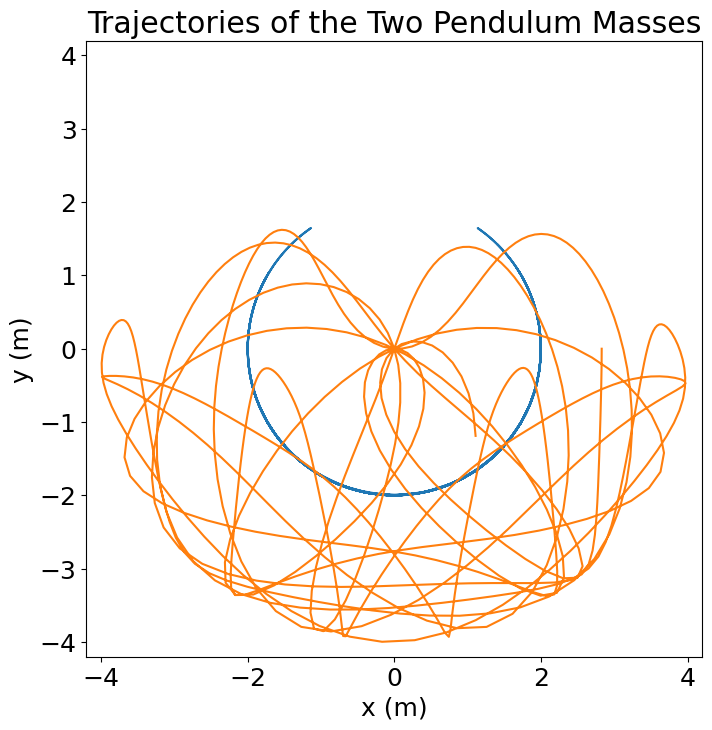

In [7]:
# Calculate and plot the 2D trajectories of both masses
X1 = np.zeros(N)
Y1 = np.zeros(N)
X2 = np.zeros(N)
Y2 = np.zeros(N)
for i in range(N):
    X1[i] = L*math.sin(u[i,0])
    Y1[i] = -L*math.cos(u[i,0])
    X2[i] = X1[i] + L*math.sin(u[i,2])
    Y2[i] = Y1[i] - L*math.cos(u[i,2])
    
fig, ax = plt.subplots(figsize=(8,8))
plt.xlim(-2.1*L, 2.1*L)
plt.ylim(-2.1*L, 2.1*L)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_aspect('equal')
plt.title('Trajectories of the Two Pendulum Masses')
ax.plot(X1,Y1)
ax.plot(X2,Y2)
plt.show()

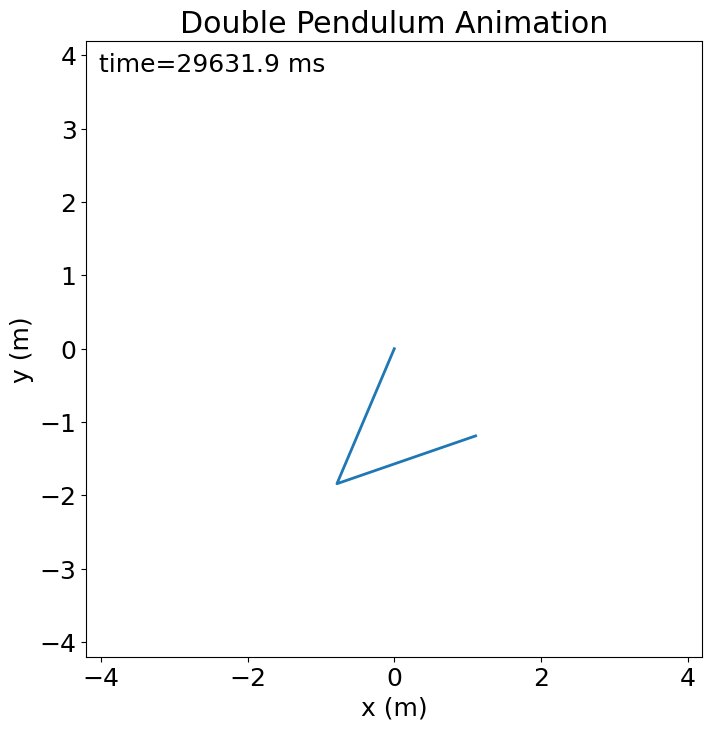

In [8]:
# Now use matplotlib to make an animation of the motion
fig = plt.figure(figsize=(8,8))
ax = plt.axes(xlim=(-2.1*L,2.1*L), ylim=(-2.1*L,2.1*L))
line, = ax.plot([],[],lw=2)
ax.set_aspect('equal')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
plt.title('Double Pendulum Animation')
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
time_step = 1000.*(t1-t0)/N

def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

def animate(i):
    XP = [0.,X1[i],X2[i]]
    YP = [0.,Y1[i],Y2[i]]
    line.set_data(XP,YP)
    time = i*time_step
    time_text.set_text('time=%.1f ms' % time)
    return line, time_text

# The animation is created here    
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=N, interval=time_step, blit=True)

# Save the animation to an mpeg file. This requires ffmpeg to be installed,
# with the executable in the PATH
anim.save('doublePendulumH.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
   
# Display the animation
plt.show()